# Hierarchical and KMeans Clustering with Scikit-Learn and SciPy

I will perform hierarchical clustering, KMeans, and hierarchical/KMeans clustering on PCA features with a dataset containing demographic information of customers, guided by [Asish Biswas' worked example](https://medium.com/towards-data-science/customer-segmentation-with-python-implementing-stp-framework-part-1-5c2d93066f82) to find segments of the customers. You can find the dataset on the linked page. 

The dataset has the following properties for 2000 customers:

* Sex -- categorical, 0: male, 1: female
* Marital status -- categorical, 0: single, 1: non-single
* Age -- numerical
* Education -- categorical, 0: unknown, 1: high school, 2: university, 3: graduate
* Income -- numerical
* Occupation -- categorical, 0: unemployed, 1: official, 2: management
* Settlement size -- categorical, 0: small city, 1: mid city, 2: big city

I will use [SciPy hierarchical clustering](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html), and [Scikit KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html), and [Scikit-learn for PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

# Data Load and Inspection

I will load the dataset and perform sanity check. Then, I will check correlations between pairs of the properties.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# For scaling
from sklearn import preprocessing

# Hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial import distance

# KMeans
from sklearn.cluster import KMeans

# Dimensional reduction with PCA
from sklearn import decomposition 

In [2]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv('_data/customers.csv', index_col=0)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 125.0 KB


In [5]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


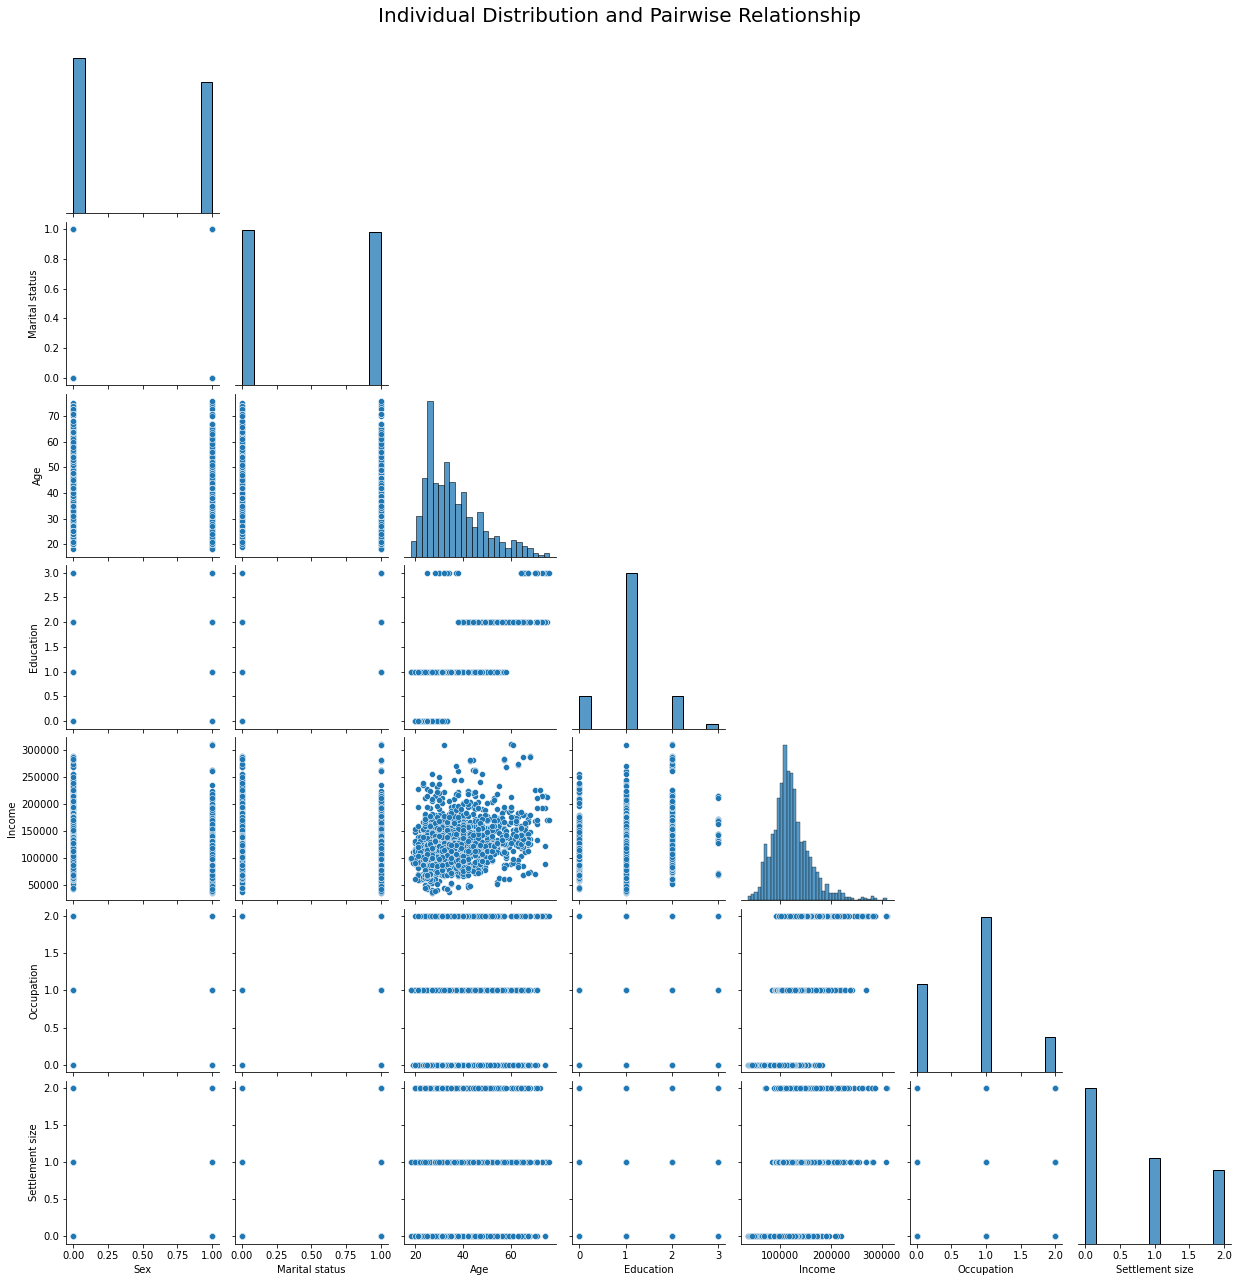

In [6]:
g = sns.pairplot(df, corner=True)
g.fig.suptitle("Individual Distribution and Pairwise Relationship", 
               y=1.02, # y= some height>1
               fontsize=20); 

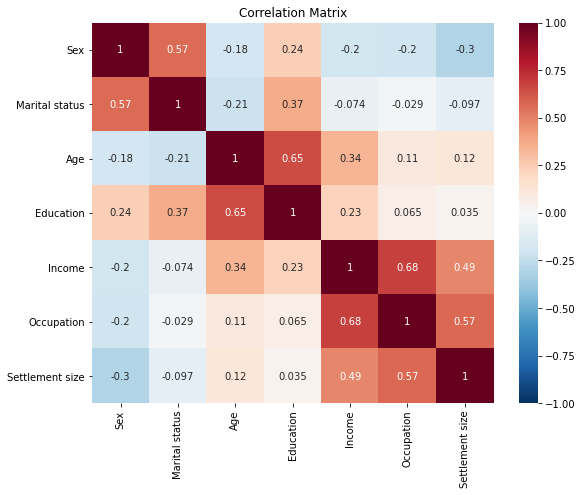

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(df.corr(),
                annot=True,
                cmap='RdBu_r',
                vmin=-1,
                vmax=1, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Correlation Matrix');

- Data sanity: no null values, and no exteme outliers. 
- Correlations of the several pairs (e.g., between the age and the education and between the occupation and the income)

# Data Scaling

In [8]:
scaler = preprocessing.StandardScaler()
data_sd = scaler.fit_transform(df)

In [9]:
df_sd = pd.DataFrame(data_sd, 
                    columns = df.columns)
df_sd.describe()

# All the properties have 1 mean value and 0 standard deviation value after scaling. 

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,3.554712e-15,5.950795e-16,1.180722e-16,-6.833423e-16,6.605827e-17,2.589706e-15,-4.455103e-15
std,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00
min,-9.173988e-01,-9.930243e-01,-1.528532e+00,-1.731068e+00,-2.234225e+00,-1.269525e+00,-9.097295e-01
25%,-9.173988e-01,-9.930243e-01,-7.603825e-01,-6.337243e-02,-6.113281e-01,-1.269525e+00,-9.097295e-01
50%,-9.173988e-01,-9.930243e-01,-2.482829e-01,-6.337243e-02,-1.418903e-01,2.968230e-01,3.212982e-01
75%,1.090038e+00,1.007025e+00,5.198664e-01,-6.337243e-02,4.492952e-01,2.968230e-01,3.212982e-01
max,1.090038e+00,1.007025e+00,3.421764e+00,3.272018e+00,4.945225e+00,1.863171e+00,1.552326e+00


# Hierarchical Clustering

In [10]:
def draw_dendrogram(linkages, title):
    plt.figure(figsize = (10, 7))
    hierarchy.dendrogram(linkages,
                     show_leaf_counts=False,
                     no_labels=True)
    plt.title(title)

In [11]:
linkages_sd = hierarchy.linkage(data_sd, method='ward')

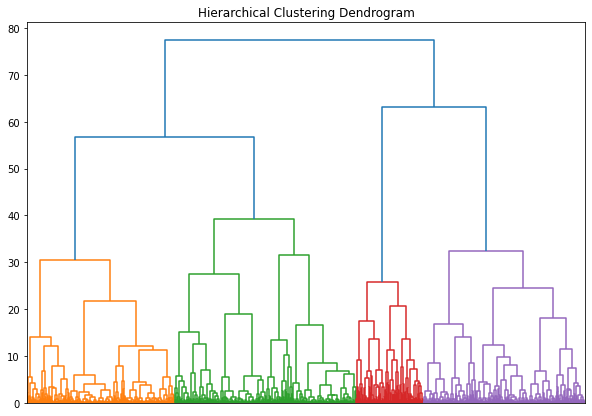

In [12]:
draw_dendrogram(linkages_sd, "Hierarchical Clustering Dendrogram")

In [13]:
hierarchy.cophenet(linkages_sd, distance.pdist(data_sd))[0]

0.5991716701553437

In [14]:
def check_clusters_labels(df, labels, median = True):
    print(list(zip(*np.unique(labels, return_counts=True))))
    if median:
        return np.round(pd.pivot_table(df, index=labels, aggfunc = [np.mean, np.median]), 2)
    else:
        return np.round(pd.pivot_table(df, index=labels, aggfunc = np.mean), 2)

In [15]:
labels_hc_sd = hierarchy.fcluster(linkages_sd, t=4, criterion='maxclust')

In [16]:
check_clusters_labels(df, labels_hc_sd, True)

[(1, 531), (2, 649), (3, 241), (4, 579)]


mean                                                                       \
     Age Education     Income Marital status Occupation Settlement size   Sex   
1  28.06      1.00  120399.59           1.00       1.08            0.84  0.71   
2  34.58      0.99   90807.33           0.45       0.10            0.02  0.64   
3  54.59      2.12  163924.68           0.72       1.26            1.22  0.50   
4  36.81      0.67  137369.34           0.00       1.18            1.25  0.00   

  median                                                                  
     Age Education  Income Marital status Occupation Settlement size Sex  
1     27         1  114369              1          1               1   1  
2     33         1   88141              0          0               0   1  
3     57         2  153645              1          1               1   0  
4     36         1  130164              0          1               1   0

# KMeans Clustering

In [17]:
def draw_eblow(data, r1, r2, title):
    distortions = []
    num_clusters = range(r1, r2)
    labels_list = []

    # Create a list of distortions from the kmeans function
    for i in num_clusters:
        km = KMeans(n_clusters=i, random_state = 42)
        labels = km.fit_predict(data_sd)
        inertia = km.inertia_
        
        distortions.append(inertia)
        labels_list.append(labels)
        
    # Create a DataFrame with two lists - num_clusters, distortions
    elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 
                               'distortions': distortions})

    # Creat a line plot of num_clusters and distortions
    sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot, marker='o')
    plt.xticks(num_clusters)
    plt.xlabel("Number of clusters")
    plt.ylabel("Sum of squared distances")
    
    plt.title(title);
    
    return labels_list

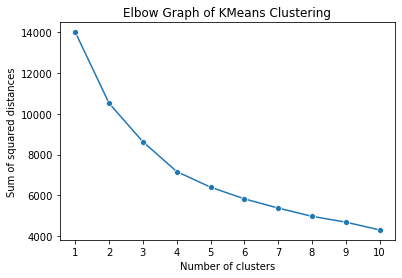

In [18]:
result = draw_eblow(data_sd, 1, 11, "Elbow Graph of KMeans Clustering")

In [19]:
labels_km_sd = result[3] # 4 clusters

In [20]:
check_clusters_labels(df, labels_km_sd, True)

[(0, 263), (1, 462), (2, 570), (3, 705)]


mean                                                                       \
     Age Education     Income Marital status Occupation Settlement size   Sex   
0  55.70      2.13  158338.42           0.69       1.13            1.11  0.50   
1  35.58      0.75   97859.85           0.02       0.33            0.04  0.35   
2  35.64      0.73  141218.25           0.17       1.27            1.52  0.03   
3  28.96      1.07  105759.12           1.00       0.63            0.42  0.85   

  median                                                                  
     Age Education  Income Marital status Occupation Settlement size Sex  
0     57         2  146716              1          1               1   1  
1     35         1   99102              0          0               0   0  
2     35         1  135629              0          1               2   0  
3     27         1  106577              1          1               0   1

avg_score: 0.24820106944568027
avg_score: 0.2711846855734802
avg_score: 0.26879180394522123
avg_score: 0.25424044566024484


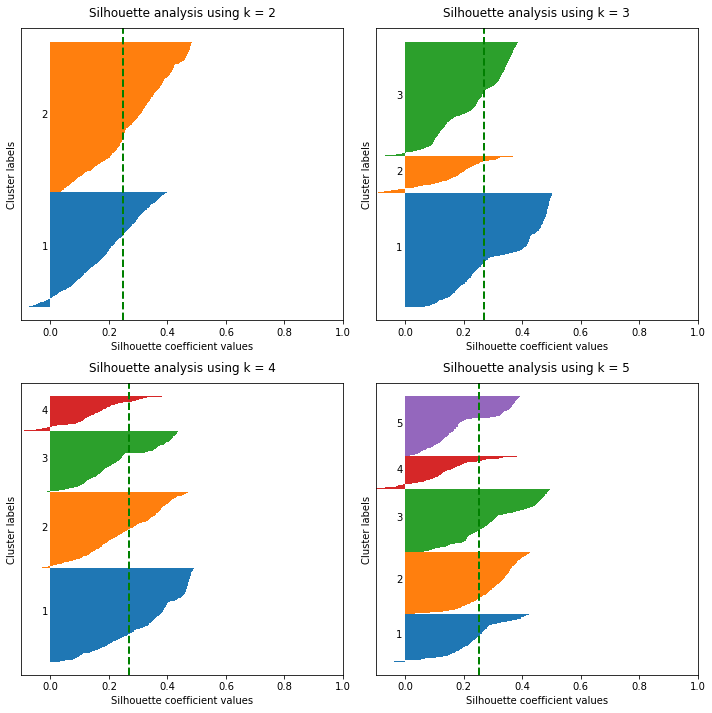

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

for i, k in enumerate([2, 3, 4, 5]):    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(data_sd)
    centroids = km.cluster_centers_
    
    # Get silhouette samples
    silhouette_vals = silhouette_samples(data_sd, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    
    for j, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax[i].barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax[i].text(-0.03, (y_lower + y_upper) / 2, str(j + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    print(f"avg_score: {avg_score}")
    
    ax[i].axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax[i].set_yticks([])
    ax[i].set_xlim([-0.1, 1])
    ax[i].set_xlabel('Silhouette coefficient values')
    ax[i].set_ylabel('Cluster labels')
    ax[i].set_title(f'Silhouette analysis using k = {k}', y=1.02)
    
plt.tight_layout();

# PCA

In [22]:
pca = decomposition.PCA()
pca.fit(data_sd)

PCA()

In [23]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

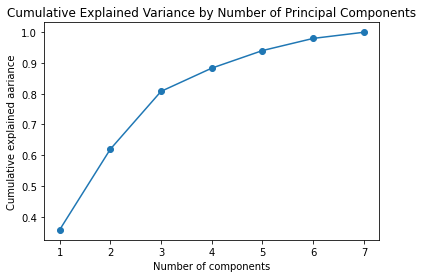

In [24]:
plt.plot(range(1, 8), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained aariance')
plt.title("Cumulative Explained Variance by Number of Principal Components");

In [25]:
pca = decomposition.PCA(n_components=3)
pca_scores = pca.fit_transform(data_sd)

In [26]:
pca.components_.round(4)

array([[-0.3147, -0.1917,  0.3261,  0.1568,  0.5245,  0.4921,  0.4648],
       [ 0.458 ,  0.5126,  0.3122,  0.6398,  0.1247,  0.0147, -0.0696],
       [-0.293 , -0.442 ,  0.6095,  0.2756, -0.1657, -0.3955, -0.2957]])

In [27]:
df_pca_components = pd.DataFrame(
    data=pca.components_.round(4),
    columns=df.columns.values,
    index=['component 1', 'component 2', 'component 3'])
df_pca_components

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
component 1,-0.3147,-0.1917,0.3261,0.1568,0.5245,0.4921,0.4648
component 2,0.4580,0.5126,0.3122,0.6398,0.1247,0.0147,-0.0696
component 3,-0.2930,-0.4420,0.6095,0.2756,-0.1657,-0.3955,-0.2957


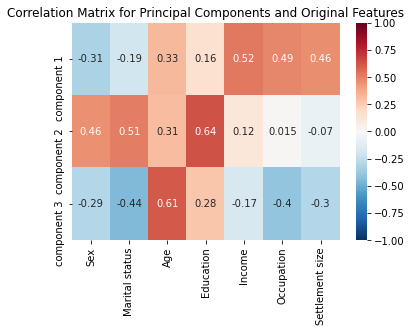

In [28]:
s = sns.heatmap(
    df_pca_components,
    vmin=-1,
    vmax=1,
    cmap='RdBu_r',
    annot=True
)
plt.title('Correlation Matrix for Principal Components and Original Features');

# Hierarchical Clustering on PCA Features

In [29]:
linkages_pca = hierarchy.linkage(pca_scores, method='ward')

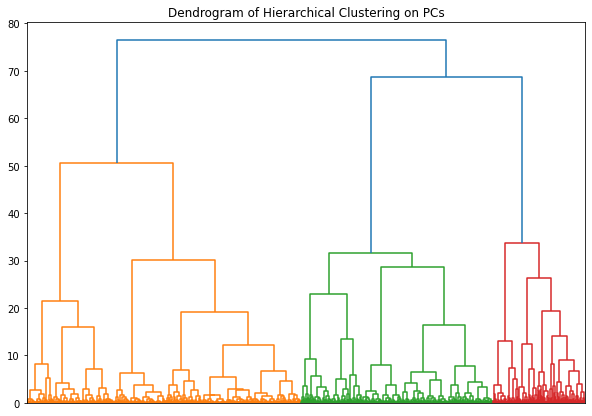

In [30]:
draw_dendrogram(linkages_pca, "Dendrogram of Hierarchical Clustering on PCs")

In [31]:
labels_hc_pca = hierarchy.fcluster(linkages_pca, t=4, criterion='maxclust')

In [32]:
check_clusters_labels(df, labels_hc_pca, False)

[(1, 314), (2, 669), (3, 688), (4, 329)]


,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
1,33.73,0.69,84890.89,0.12,0.03,0.00,0.34
2,28.27,1.00,107425.47,0.92,0.71,0.45,0.88
3,35.61,0.72,138397.37,0.15,1.22,1.29,0.04
4,54.14,2.10,146407.50,0.70,0.91,0.89,0.57


In [33]:
df_hc_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)
df_hc_pca.columns.values[-3:] = ['component 1', 'component 2', 'component 3']
df_hc_pca['label'] = labels_hc_pca

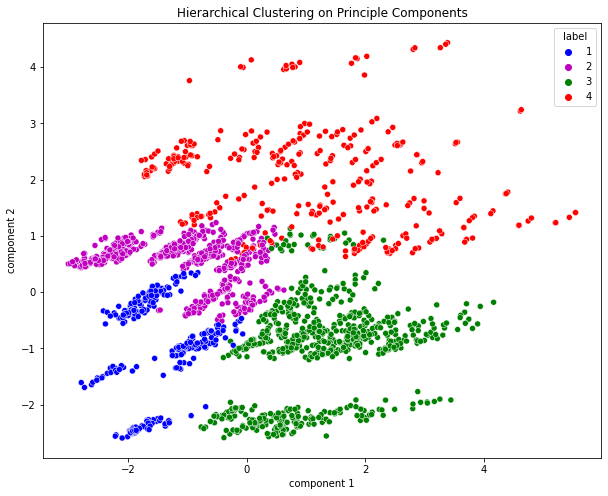

In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_hc_pca['component 1'],
    y=df_hc_pca['component 2'],
    hue=df_hc_pca['label'],
    palette=['b','m','g','r']
)

plt.title('Hierarchical Clustering on Principle Components');

# KMeans on PCA Features

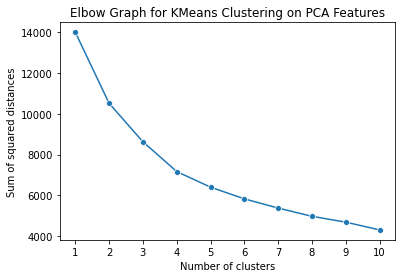

In [35]:
r = draw_eblow(pca_scores, 1, 11, "Elbow Graph for KMeans Clustering on PCA Features");

In [36]:
labels_km_pca = r[3] # 4 clusters

In [37]:
check_clusters_labels(df, labels_km_pca, False)

[(0, 263), (1, 462), (2, 570), (3, 705)]


,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
0,55.70,2.13,158338.42,0.69,1.13,1.11,0.50
1,35.58,0.75,97859.85,0.02,0.33,0.04,0.35
2,35.64,0.73,141218.25,0.17,1.27,1.52,0.03
3,28.96,1.07,105759.12,1.00,0.63,0.42,0.85


In [38]:
df_km_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)
df_km_pca.columns.values[-3:] = ['component 1', 'component 2', 'component 3']
df_km_pca['label'] = labels_km_pca

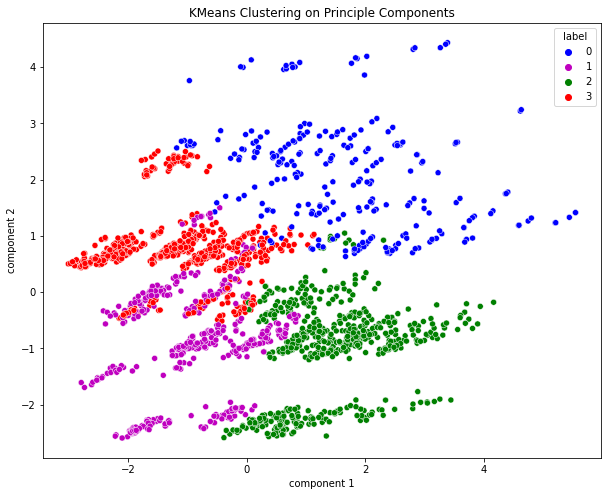

In [39]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_km_pca['component 1'],
    y=df_km_pca['component 2'],
    hue=df_km_pca['label'],
    palette=['b','m','g','r']
)

plt.title('KMeans Clustering on Principle Components');

# Comparison

In [40]:
df_hc = df.copy()
df_hc['label'] = labels_hc_sd

df_km = df.copy()
df_km['label'] = labels_km_sd

df_hc_pca = df.copy()
df_hc_pca['label'] = labels_hc_pca

df_km_pca = df.copy()
df_km_pca['label'] = labels_km_pca

In [41]:
def check_clusters_labels_included(df, median = True):
    if median:
        return np.round(pd.pivot_table(df, index=['label'], aggfunc = [np.mean, np.median]), 2)
    else:
        return np.round(pd.pivot_table(df, index=['label']), 2)

In [42]:
check_clusters_labels_included(df_hc, False)

,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,28.06,1.00,120399.59,1.00,1.08,0.84,0.71
2,34.58,0.99,90807.33,0.45,0.10,0.02,0.64
3,54.59,2.12,163924.68,0.72,1.26,1.22,0.50
4,36.81,0.67,137369.34,0.00,1.18,1.25,0.00


In [43]:
check_clusters_labels_included(df_km, False)

,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
0,55.70,2.13,158338.42,0.69,1.13,1.11,0.50
1,35.58,0.75,97859.85,0.02,0.33,0.04,0.35
2,35.64,0.73,141218.25,0.17,1.27,1.52,0.03
3,28.96,1.07,105759.12,1.00,0.63,0.42,0.85


In [44]:
check_clusters_labels_included(df_hc_pca, False)

,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,33.73,0.69,84890.89,0.12,0.03,0.00,0.34
2,28.27,1.00,107425.47,0.92,0.71,0.45,0.88
3,35.61,0.72,138397.37,0.15,1.22,1.29,0.04
4,54.14,2.10,146407.50,0.70,0.91,0.89,0.57


In [45]:
check_clusters_labels_included(df_km_pca, False)

,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
0,55.70,2.13,158338.42,0.69,1.13,1.11,0.50
1,35.58,0.75,97859.85,0.02,0.33,0.04,0.35
2,35.64,0.73,141218.25,0.17,1.27,1.52,0.03
3,28.96,1.07,105759.12,1.00,0.63,0.42,0.85


In [46]:
def switch_label(x):
    if x == 3: return 4
    elif x == 4: return 3
    else: return x
    
df_hc['label'] = df_hc['label'].apply(switch_label)

In [47]:
def switch_label(x):
    if x == 0: return 4
    elif x == 1: return 2
    elif x == 2: return 3
    elif x == 3: return 1
    
df_km['label'] = df_km['label'].apply(switch_label)

In [48]:
def switch_label(x):
    if x == 1: return 2
    elif x == 2: return 1
    else: return x
    
df_hc_pca['label'] = df_hc_pca['label'].apply(switch_label)

In [49]:
def switch_label(x):
    if x == 0: return 4
    elif x == 1: return 2
    elif x == 2: return 3
    elif x == 3: return 1
    else: return x
    
df_km_pca['label'] = df_km_pca['label'].apply(switch_label)

In [50]:
check_clusters_labels_included(df_hc, False)
check_clusters_labels_included(df_km, False)
check_clusters_labels_included(df_hc_pca, False)
check_clusters_labels_included(df_km_pca, False)

,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,28.06,1.00,120399.59,1.00,1.08,0.84,0.71
2,34.58,0.99,90807.33,0.45,0.10,0.02,0.64
3,36.81,0.67,137369.34,0.00,1.18,1.25,0.00
4,54.59,2.12,163924.68,0.72,1.26,1.22,0.50


,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,28.96,1.07,105759.12,1.00,0.63,0.42,0.85
2,35.58,0.75,97859.85,0.02,0.33,0.04,0.35
3,35.64,0.73,141218.25,0.17,1.27,1.52,0.03
4,55.70,2.13,158338.42,0.69,1.13,1.11,0.50


,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,28.27,1.00,107425.47,0.92,0.71,0.45,0.88
2,33.73,0.69,84890.89,0.12,0.03,0.00,0.34
3,35.61,0.72,138397.37,0.15,1.22,1.29,0.04
4,54.14,2.10,146407.50,0.70,0.91,0.89,0.57


,Age,Education,Income,Marital status,Occupation,Settlement size,Sex
label,,,,,,,
1,28.96,1.07,105759.12,1.00,0.63,0.42,0.85
2,35.58,0.75,97859.85,0.02,0.33,0.04,0.35
3,35.64,0.73,141218.25,0.17,1.27,1.52,0.03
4,55.70,2.13,158338.42,0.69,1.13,1.11,0.50


In [51]:
df_hc_cat = df_hc.copy()
df_km_cat = df_km.copy()
df_hc_pca_cat = df_hc_pca.copy()
df_km_pca_cat = df_km_pca.copy()

In [52]:
dfs = {'df_hc_cat': df_hc_cat, 
        'df_km_cat': df_km_cat, 
        'df_hc_pca_cat': df_hc_pca_cat, 
        'df_km_pca_cat': df_km_pca_cat}

def label_to_category(df):
    df['label'] = df['label'].astype('category')

for key in dfs:
    label_to_category(dfs[key])

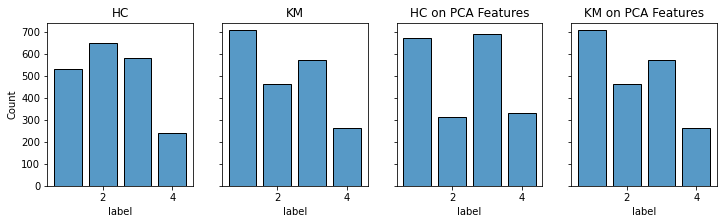

In [53]:
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (12, 3))
sns.histplot(df_hc, x='label', shrink=0.8, bins = [1, 2, 3, 4], discrete=True, ax = ax[0])
ax[0].set_title('HC')
sns.histplot(df_km, x='label', shrink=0.8, bins = [1, 2, 3, 4], discrete=True, ax = ax[1])
ax[1].set_title('KM')
sns.histplot(df_hc_pca, x='label', shrink=0.8, bins = [1, 2, 3, 4], discrete=True, ax = ax[2])
ax[2].set_title('HC on PCA Features')
sns.histplot(df_km_pca, x='label', shrink=0.8, bins = [1, 2, 3, 4], discrete=True, ax = ax[3])
ax[3].set_title('KM on PCA Features');

## Rand Score

In [54]:
from sklearn.metrics.cluster import adjusted_rand_score

labels_values = [labels_hc_sd, labels_km_sd, labels_hc_pca, labels_km_pca]

labels_names = ['HC', 'KM', 'HC_PCA', 'KM_PCA']

for i, val in enumerate(labels_values):
    j = i+1
    while j < len(labels_names):
        print(f"{labels_names[i]} vs {labels_names[j]}: \
        {adjusted_rand_score(labels_values[i], labels_values[j])}")
        j+=1

HC vs KM:         0.46848715637531313
HC vs HC_PCA:         0.5470502695885617
HC vs KM_PCA:         0.46848715637531313
KM vs HC_PCA:         0.6692561523376825
KM vs KM_PCA:         1.0
HC_PCA vs KM_PCA:         0.6692561523376825


# Exploration of Segments

## Univariate exploration

In [55]:
df_km_pca.rename(columns = {'label': 'Segment'}, inplace = True)
df_km_pca_cat.rename(columns = {'label': 'Segment'}, inplace = True)

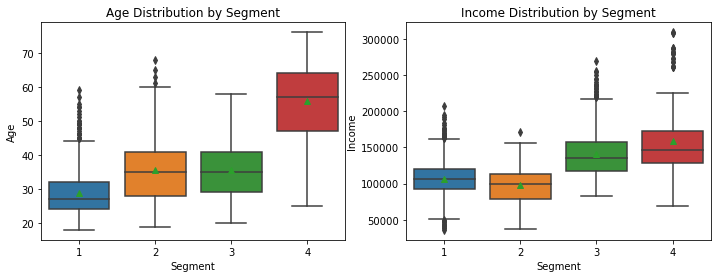

In [56]:
# Boxplots of numeric variables
fig, ax = plt.subplots(1,2, figsize = (12, 4))

sns.boxplot(data=df_km_pca_cat, x="Segment", y='Age', showmeans=True, ax = ax[0])
ax[0].set_title('Age Distribution by Segment')

sns.boxplot(data=df_km_pca_cat, x="Segment", y='Income', showmeans=True, ax = ax[1])
ax[1].set_title('Income Distribution by Segment');

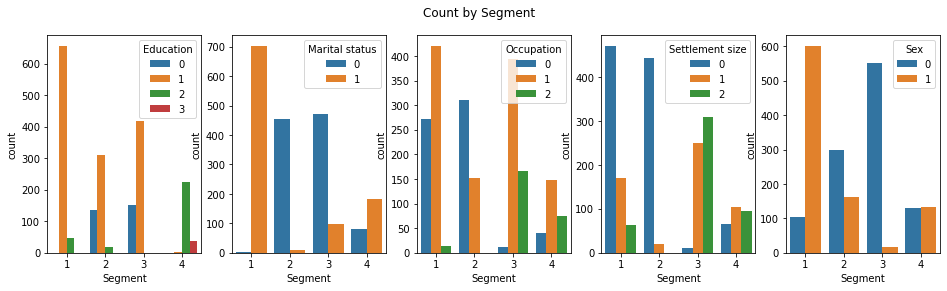

In [57]:
# Count of categorical variables
variables = ['Education', 'Marital status', 'Occupation', 'Settlement size', 'Sex']

fig, ax = plt.subplots(1, 5, figsize = (16, 4));
for idx, val in enumerate(variables):
    sns.countplot(x='Segment', hue=val, data = df_km_pca, ax=ax[idx])
fig.suptitle('Count by Segment');

## Bivariate exploration

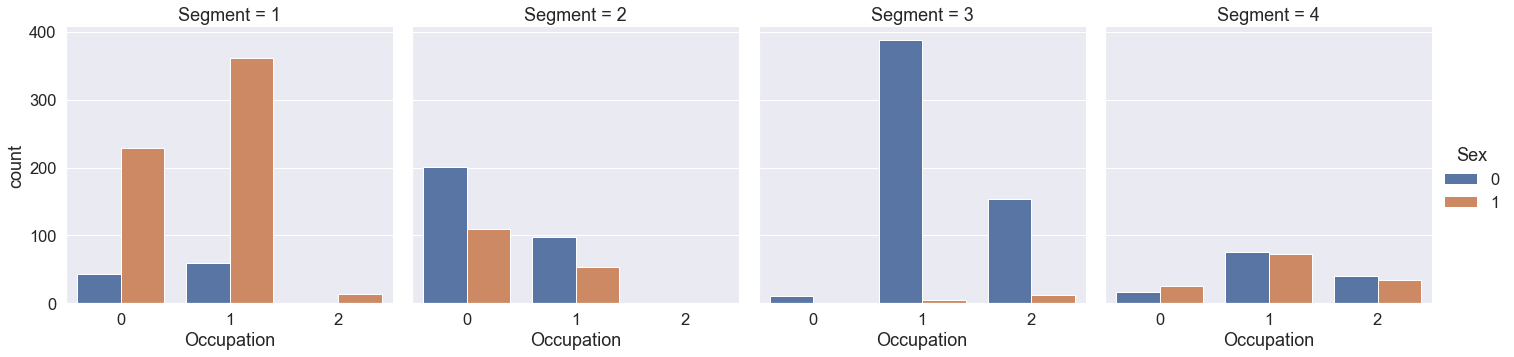

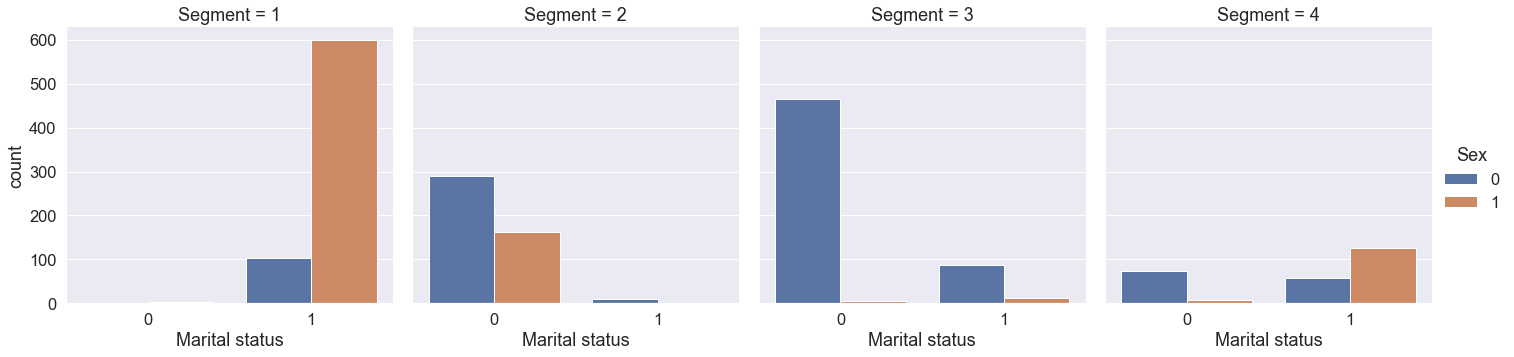

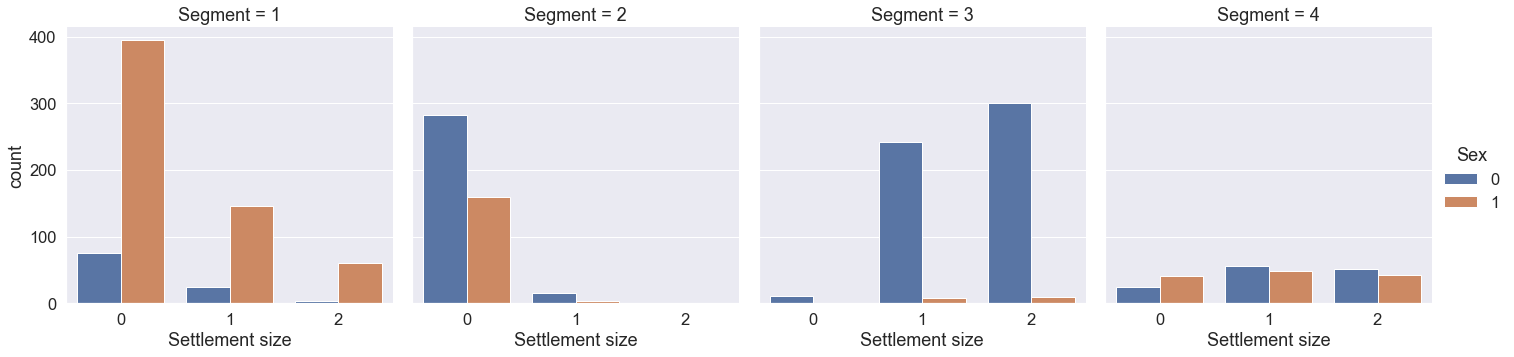

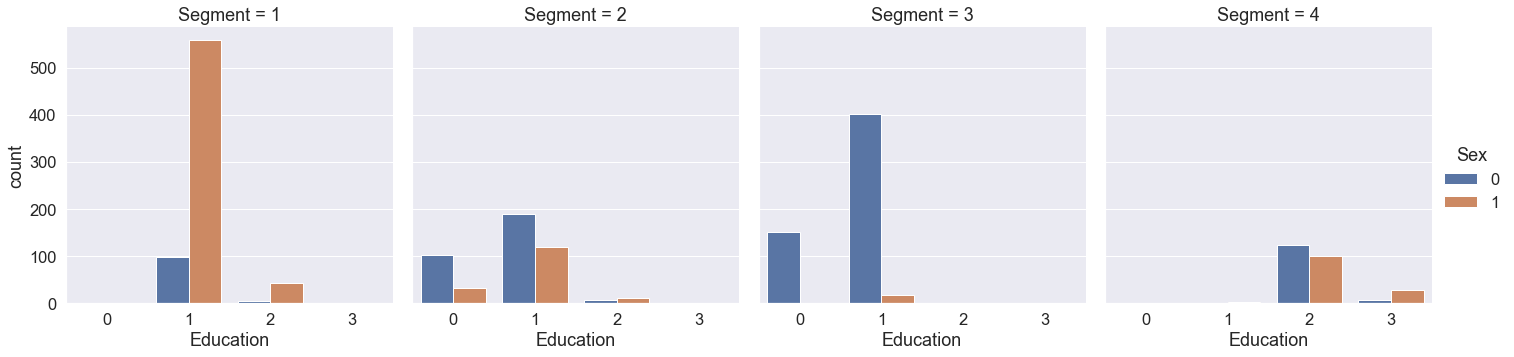

In [58]:
# 'Sex' and other variables
sns.set(font_scale=1.5)
sns.catplot(data=df_km_pca, x='Occupation', hue='Sex', col = 'Segment', kind ='count')
sns.catplot(data=df_km_pca, x='Marital status', hue='Sex', col = 'Segment', kind ='count')
sns.catplot(data=df_km_pca, x='Settlement size', hue='Sex', col = 'Segment', kind ='count')
sns.catplot(data=df_km_pca, x='Education', hue='Sex', col = 'Segment', kind ='count');

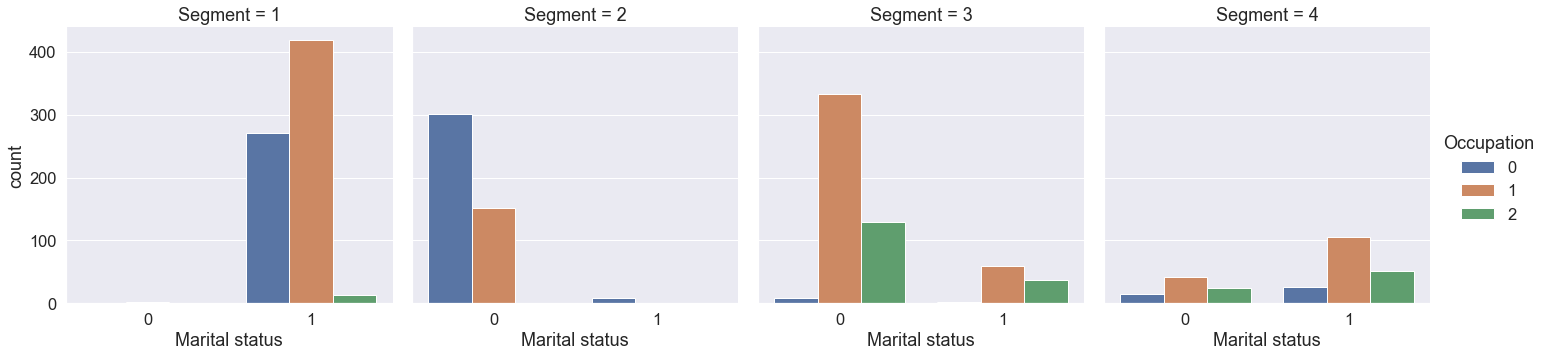

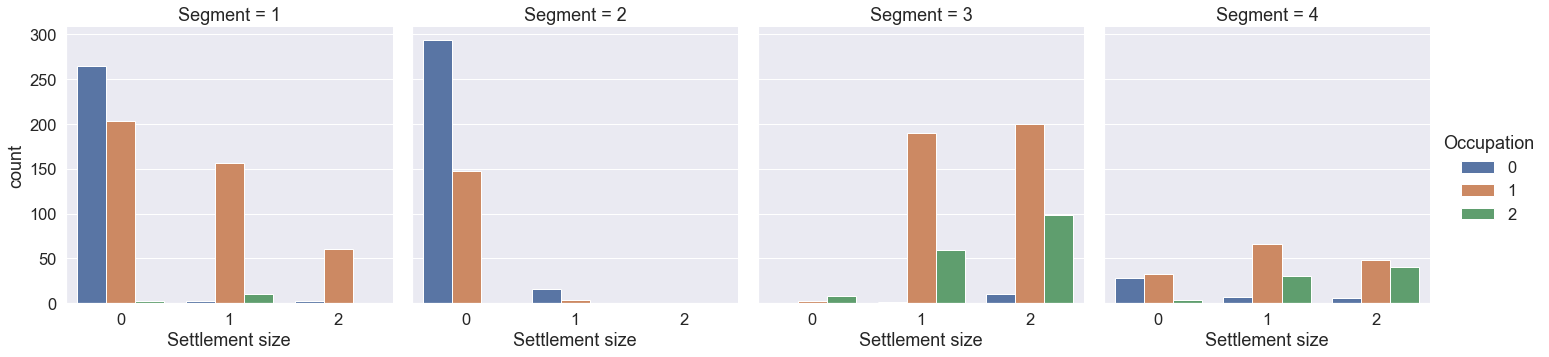

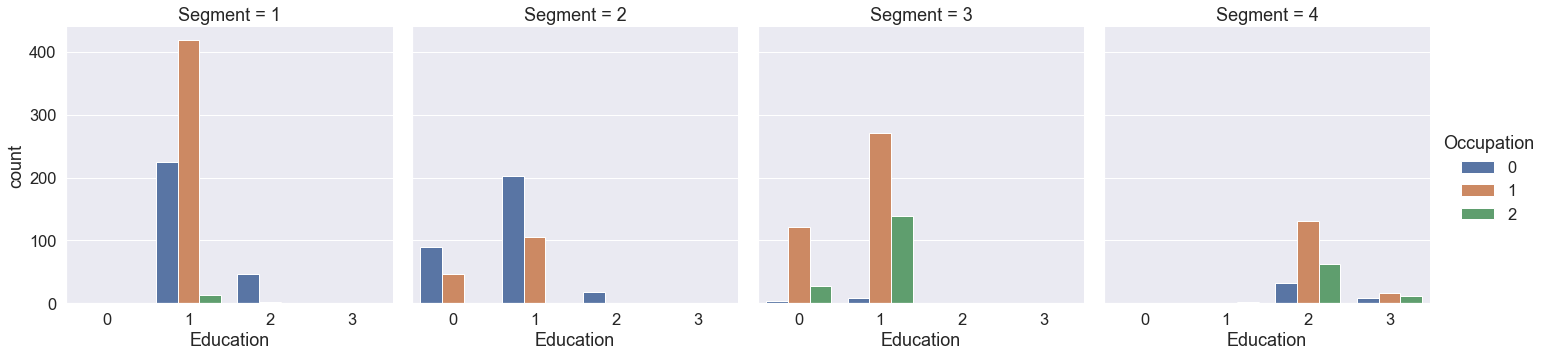

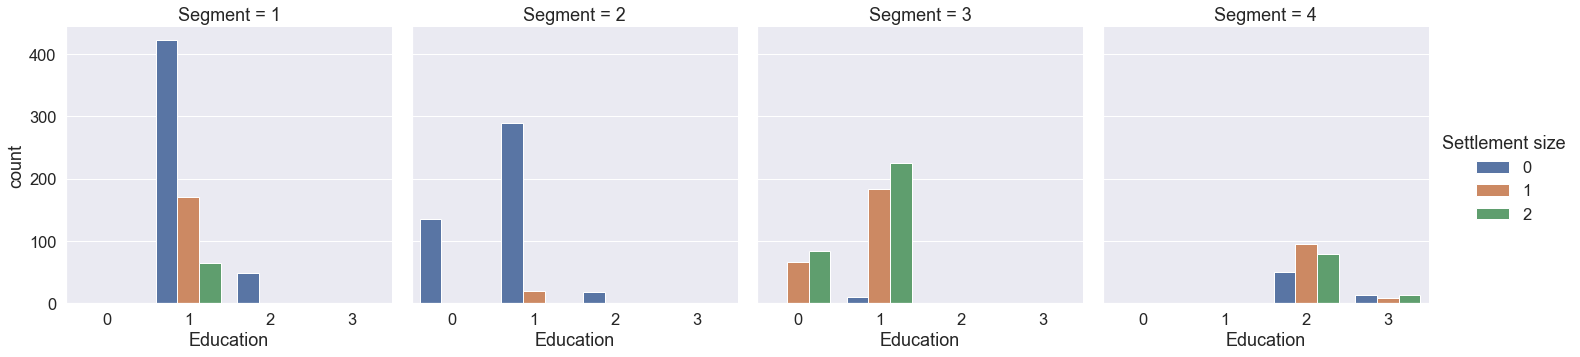

In [59]:
# 'Occupation' and other variables
sns.catplot(data=df_km_pca, x='Marital status', hue='Occupation', col = 'Segment', kind ='count')
sns.catplot(data=df_km_pca, x='Settlement size', hue='Occupation', col = 'Segment', kind ='count')
sns.catplot(data=df_km_pca, x='Education', hue='Occupation', col = 'Segment', kind ='count')

# 'Education' and 'Settlement size'
sns.catplot(data=df_km_pca, x='Education', hue='Settlement size', col = 'Segment', kind ='count');